__Support Vector Machine Implementation for Predicting Stock Price Movement__

In [260]:
# Implementing Support Vector machines model on dataset for stock price prediction
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import yfinance as yf
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle

# Importing the dataset
#initial_df = pd.read_csv('SP500_stock_dataset_PE.csv', delimiter=',')
initial_df = pd.read_csv('SP500_stock_prices.csv', delimiter=',')
# Make date column the index
initial_df = initial_df.set_index('Date')

initial_df.head()

,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2015-08-03,MMM,150.789993,148.940002,151.779999,150.119995,2355100,Industrials
2015-08-04,MMM,150.929993,150.110001,151.539993,150.399994,1811900,Industrials
2015-08-05,MMM,151.850006,150.919998,153.240005,151.009995,1765600,Industrials
2015-08-06,MMM,150.889999,148.899994,151.220001,149.259995,1764800,Industrials
2015-08-07,MMM,148.479996,148.160004,150.000000,148.889999,1668700,Industrials


In [261]:
# only display year, month and day in index
initial_df.index = pd.to_datetime(initial_df.index).date
initial_df_test = initial_df.copy()
data = initial_df
data
# make return column
data['Return'] = data['Close'].pct_change()

In [262]:
print(data['Sector'].unique())
# assign each different Sector string its own number
data['Sector'] = data['Sector'].map({'Consumer Discretionary': 0, 'Consumer Staples': 1, 'Energy': 2, 'Financials': 3, 'Health Care': 4, 'Industrials': 5, 'Information Technology': 6, 'Materials': 7, 'Real Estate': 8, 'Communication Services': 9, 'Utilities': 10})

['Industrials' 'Health Care' 'Information Technology'
 'Communication Services' 'Consumer Staples' 'Consumer Discretionary'
 'Utilities' 'Financials' 'Materials' 'Real Estate' 'Energy']


In [263]:
# make a new column for whether or not the price has increased or decreased from the previous 63 days
# 1 = increased, 0 = decreased, doing so by comparing close price of today with close price of 63 days ago
data['63-day Price Movement'] = np.where(data['Close'] > data['Close'].shift(-63), 1, 0)

In [264]:
# Make the tickers to categoricals, but keep the original order of the tickers
data['Ticker'] = pd.Categorical(data['Ticker'], categories=data['Ticker'].unique(), ordered=True)
data['Ticker'] = data['Ticker'].cat.codes

In [265]:
# select only the ticker index
indiviual_datas = []

for ticker in data['Ticker'].unique():
    #data_ticker = data.xs(0, level=1).copy()
    data_ticker = data[data['Ticker'] == ticker].copy()
    # make target column
    data_ticker['Target'] = data_ticker['63-day Price Movement'].shift(-63)
    #data['Price Movement 62 Days'] = data['Price Movement'].shift(62)
    data_ticker.dropna(inplace=True)
    data_ticker

    indiviual_datas.append(data_ticker)

data_all_tickers = pd.concat(indiviual_datas)

data_all_tickers

,Ticker,Open,Low,High,Close,Volume,Sector,Return,63-day Price Movement,Target
2015-08-04,0,150.929993,150.110001,151.539993,150.399994,1811900,5,0.001865,0,1.0
2015-08-05,0,151.850006,150.919998,153.240005,151.009995,1765600,5,0.004056,0,1.0
2015-08-06,0,150.889999,148.899994,151.220001,149.259995,1764800,5,-0.011589,0,1.0
2015-08-07,0,148.479996,148.160004,150.000000,148.889999,1668700,5,-0.002479,0,1.0
2015-08-10,0,150.000000,149.889999,151.399994,151.240005,1571800,5,0.015784,0,1.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,497,132.210007,131.289993,133.080002,132.919998,442500,4,0.004155,1,0.0
2019-12-26,497,133.190002,132.320007,133.190002,133.029999,929400,4,0.000828,1,0.0
2019-12-27,497,133.399994,132.380005,133.479996,133.250000,1296100,4,0.001654,1,0.0
2019-12-30,497,133.570007,131.809998,133.660004,132.210007,942000,4,-0.007805,1,0.0


In [266]:
# Splitting the dataset into the Training set and Test set according to date
# Define the specific date to split the DataFrame
# Create an offset of 62 Business days
# bd = pd.tseries.offsets.BusinessDay(n = 63)
# split_date = pd.to_datetime('2019-09-30') - bd

# # set a start date for the training set to be 62 days after the first date in the dataset
# start_date = pd.to_datetime('2016-01-04') + bd

# small test dataset creation:

bd = pd.tseries.offsets.BusinessDay(n = 63)
split_date = pd.to_datetime('2019-12-27') - bd
start_date = pd.to_datetime('2018-09-30') + bd


# Split the DataFrame into training and test sets based on the specific date
# for train we want all the data from the start date to the split date, this ensures that we have 63 days of data for each stock
# for test we want all the data from the split date to the end of the dataset
train = data_all_tickers.loc[(start_date < data_all_tickers.index) & (data_all_tickers.index < split_date)]
train_log = train
train_log['Low'] = np.log(train_log['Low'])
train_log['High'] = np.log(train_log['High'])
train_log['Open'] = np.log(train_log['Open'])
train_log['Close'] = np.log(train_log['Close'])
train_log['Volume'] = np.log(train_log['Volume']).apply(lambda x: np.log(x) if x > 0 else 0)
#train_log['Volume'] = np.log(train_log['Volume'])
test = data_all_tickers.loc[data_all_tickers.index >= split_date]
test_log = test
test_log['Low'] = np.log(test_log['Low'])
test_log['High'] = np.log(test_log['High'])
test_log['Open'] = np.log(test_log['Open'])
test_log['Close'] = np.log(test_log['Close'])
test_log['Volume'] = np.log(test_log['Volume']).apply(lambda x: np.log(x) if x > 0 else 0)
#X_train = train_log[['Ticker','Close', 'Volume', 'Sector']]
X_train = train_log[['Ticker','Open', 'Low', 'High','Close', 'Volume', 'Sector']]
y_train = train['Target']
X_test = test_log[['Ticker', 'Open', 'Low', 'High','Close', 'Volume', 'Sector']]
#X_test = test_log[['Ticker', 'Close', 'Volume', 'Sector']]
y_test = test['Target']

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\nicol\AppData\Local\Temp\ipykernel_19152\2708441104.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_log['Low'] = np.log(train_log['Low'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_19152\2708441104.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [270]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM model
model = SVC(kernel='rbf',probability=True) # linear, rbf, poly, sigmoid
model.fit(X_train, y_train)

SVC(probability=True)

In [206]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# shuffle the data, but ensure that the X and y data are shuffled in the same way.
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=69)

# Convert categorical variables to dummy variables
X_train_shuffled = pd.get_dummies(X_train_shuffled, columns=['Ticker', 'Sector'])

# Split the data into training and testing sets
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_train_shuffled, y_train_shuffled, test_size=0.2, random_state=42)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train_RF, y_train_RF)

# Make predictions on the test set
y_pred = rf.predict(X_test_RF)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_RF, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')




Root Mean Squared Error: 0.3897910960206962


In [209]:

# Get feature importances
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({"feature": X_train.columns, "importance": importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Print the feature importances
print(feature_importances[0:20])


        feature  importance
4        Volume    0.173235
2          High    0.142522
3         Close    0.137208
0          Open    0.136931
1           Low    0.132762
503    Sector_2    0.013996
507    Sector_6    0.003647
506    Sector_5    0.003603
504    Sector_3    0.003530
509    Sector_8    0.003381
501    Sector_0    0.003328
508    Sector_7    0.003315
505    Sector_4    0.003238
502    Sector_1    0.002876
511   Sector_10    0.002417
417  Ticker_414    0.002295
510    Sector_9    0.002206
53    Ticker_48    0.001989
413  Ticker_410    0.001783
212  Ticker_208    0.001742


In [271]:
# get probabilities for each class (training set)
y_pred_proba_train = model.predict_proba(X_train)
y_scores_train = y_pred_proba_train[:, 1]

In [272]:

# Get the probabilities for each class
y_pred_proba_test = model.predict_proba(X_test)
# predicted probabilities for the positive class
y_scores_test = y_pred_proba_test[:, 1]

In [273]:
# save the y_pred_proba_test to a csv file
y_pred_proba_test_df = pd.DataFrame(y_pred_proba_test)
y_pred_proba_test_df.to_csv('SVM_y_pred_proba_test.csv')

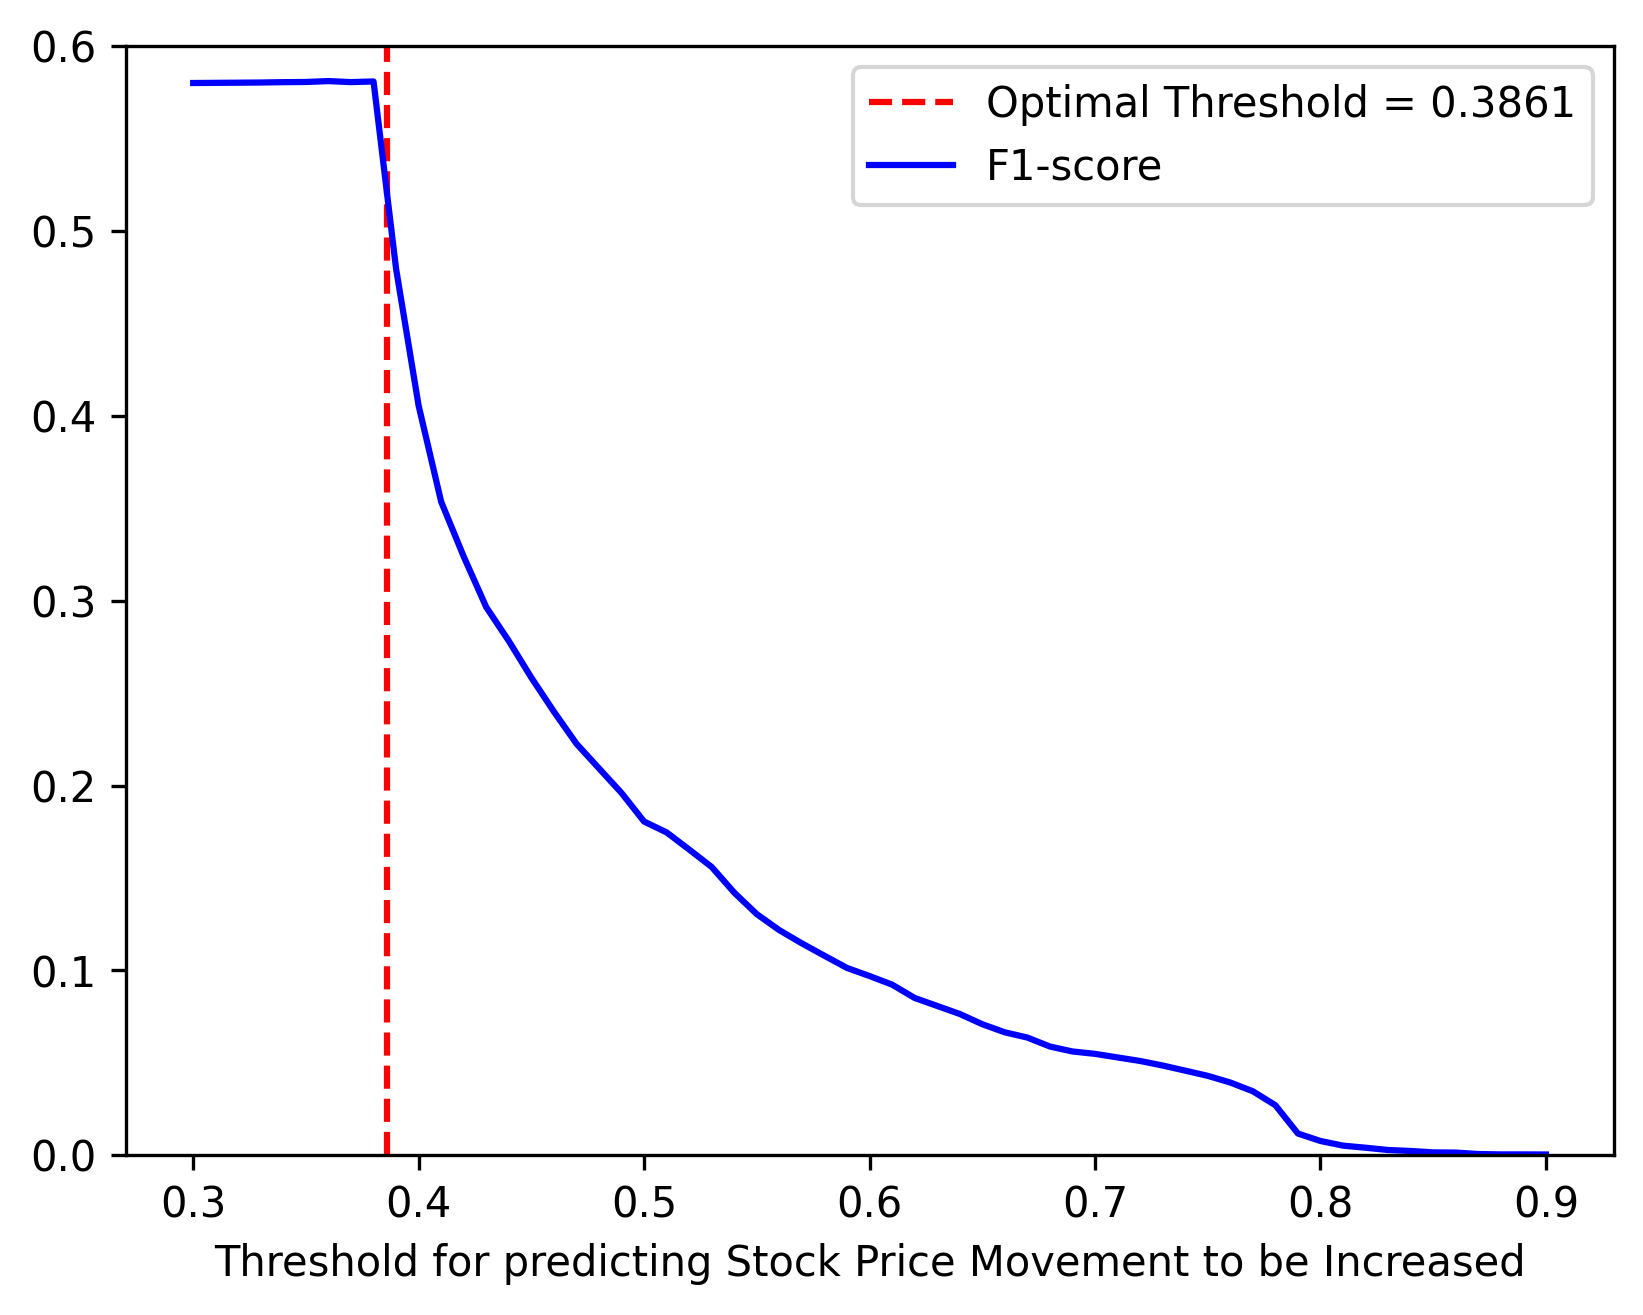

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

precision = []
recall = []
f1 = []
thresholds = np.arange(0.3, 0.9, 0.01)
for threshold in thresholds:
    y_pred = (y_scores_train > threshold).astype(int)
    precision.append(precision_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    f1.append(f1_score(y_train, y_pred))
    
# Create a new figure with a dpi of 300
plt.figure(dpi=300)
# make line at threshold 0.3859
plt.plot([0.3861, 0.3861], [0, 0.6], linestyle='--', label='Optimal Threshold = 0.3861', color='r')
plt.plot(thresholds, f1, label='F1-score',color='b')
plt.xlabel('Threshold for predicting Stock Price Movement to be Increased')
plt.ylim([0, 0.6])
plt.legend()
plt.show()



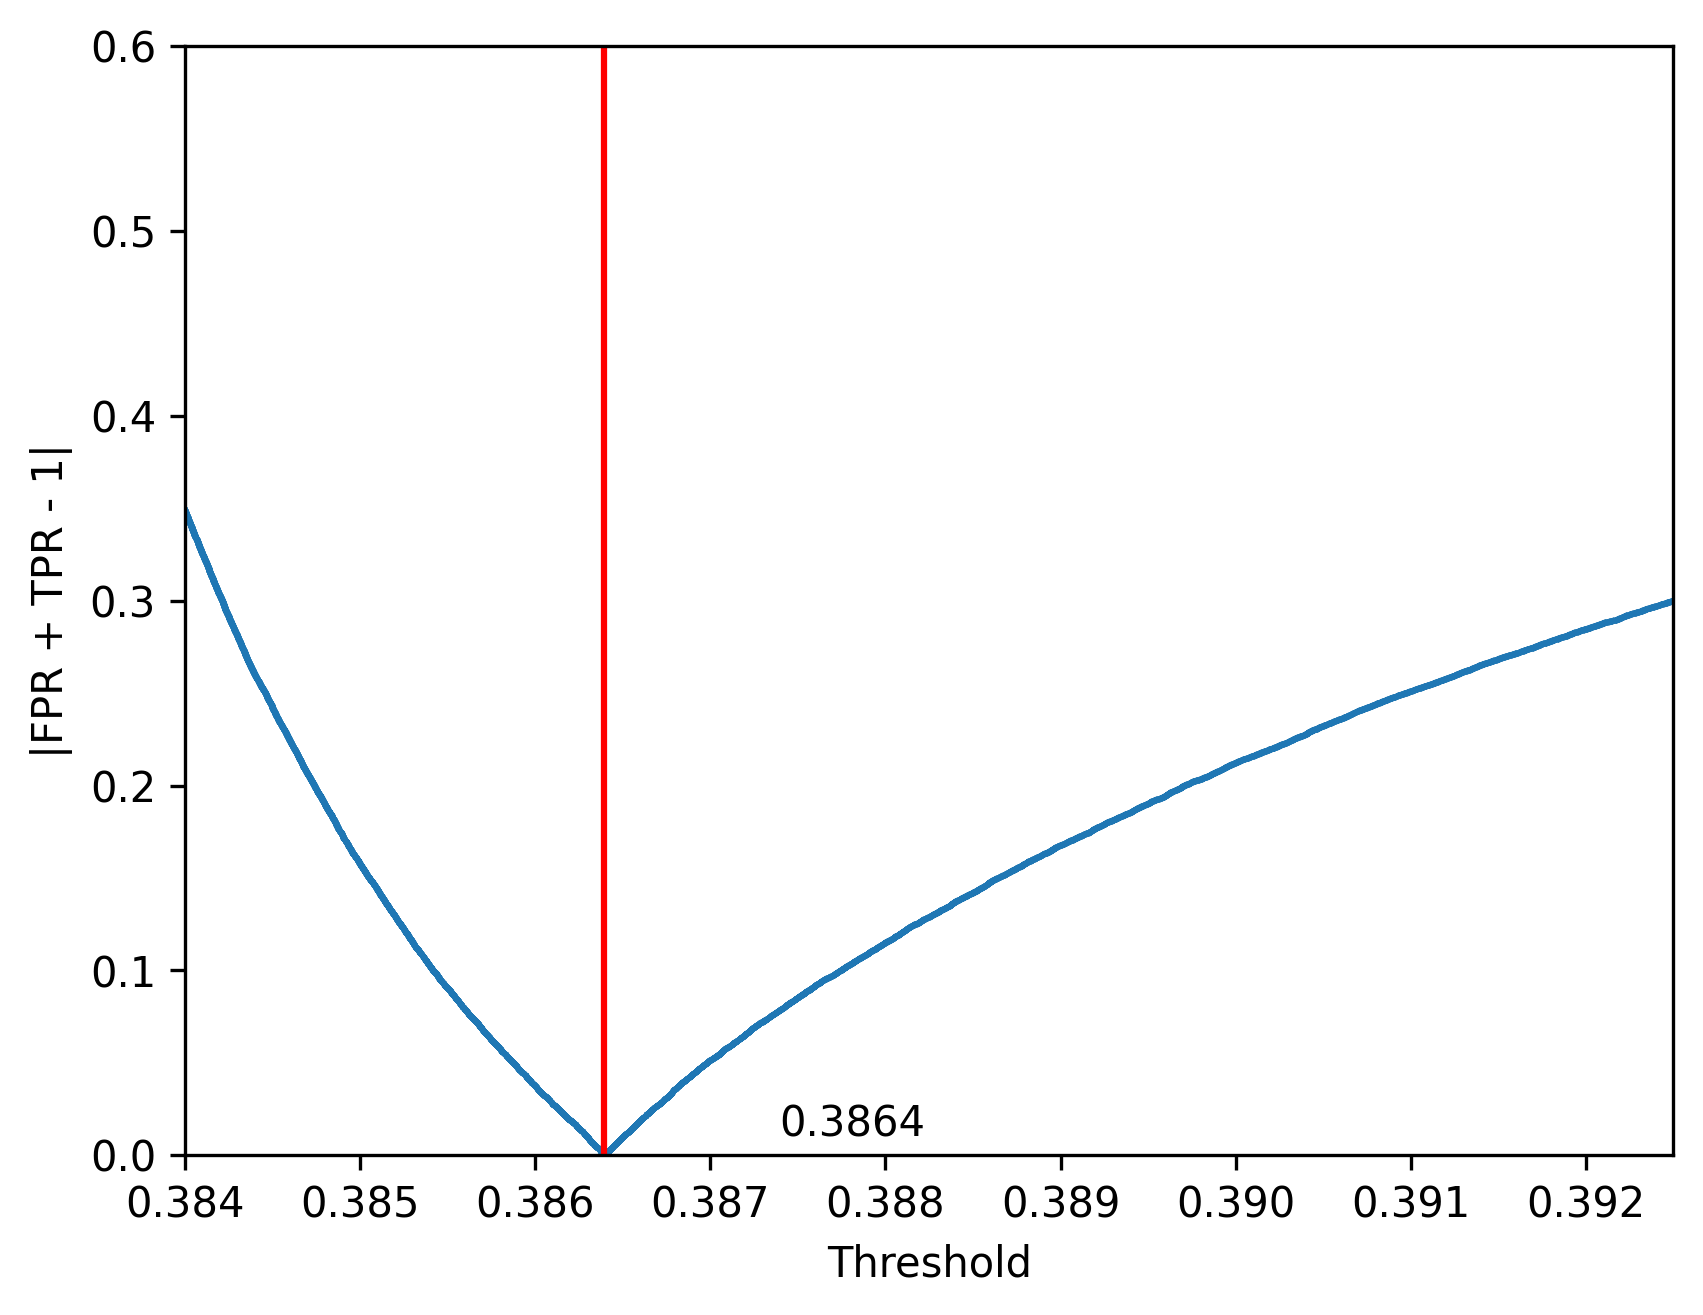

In [274]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_train, drop_intermediate=False)

# Create a new figure with a dpi of 300
plt.figure(dpi=300)

plt.scatter(thresholds, np.abs(fpr + tpr - 1), s=0.1)
plt.xlabel("Threshold")

# let x-axis go from 0.384 to 0.3925
plt.xlim([0.384,0.3925])
plt.ylabel("|FPR + TPR - 1|")

# plot the vertical line at the best threshold for FPR + TPR - 1
plt.axvline(x=thresholds[np.argmin(np.abs(fpr + tpr - 1))], color='r')

# plot the exact threshold value for FPR + TPR - 1
plt.text(thresholds[np.argmin(np.abs(fpr + tpr - 1))] + 0.001, 0.01, str(round(thresholds[np.argmin(np.abs(fpr + tpr - 1))], 4)))
plt.ylim([0,0.6])
plt.show()


In [275]:
from sklearn.metrics import f1_score
# Create a list of possible thresholds and f1 scores
thresholds = np.arange(0.3864, 0.5, 0.001)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_scores_train > threshold).astype(int)
    score = f1_score(y_train, y_pred)
    f1_scores.append(score)

# Find the threshold that gave the highest f1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
optimal_score = np.max(f1_scores)

print(f"Optimal threshold is: {optimal_threshold}")
print(f"Highest F1 score at optimal threshold is: {optimal_score}")

Optimal threshold is: 0.3864
Highest F1 score at optimal threshold is: 0.5230092368100482


In [276]:
# Set custom threshold
threshold = optimal_threshold

# Make a prediction using the trained SVM model with the custom threshold applied
y_pred = (y_pred_proba_test[:,1] > threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.37670110887096775


In [277]:
print(sum(y_pred))

15550


In [278]:
print(len(y_pred))

31744


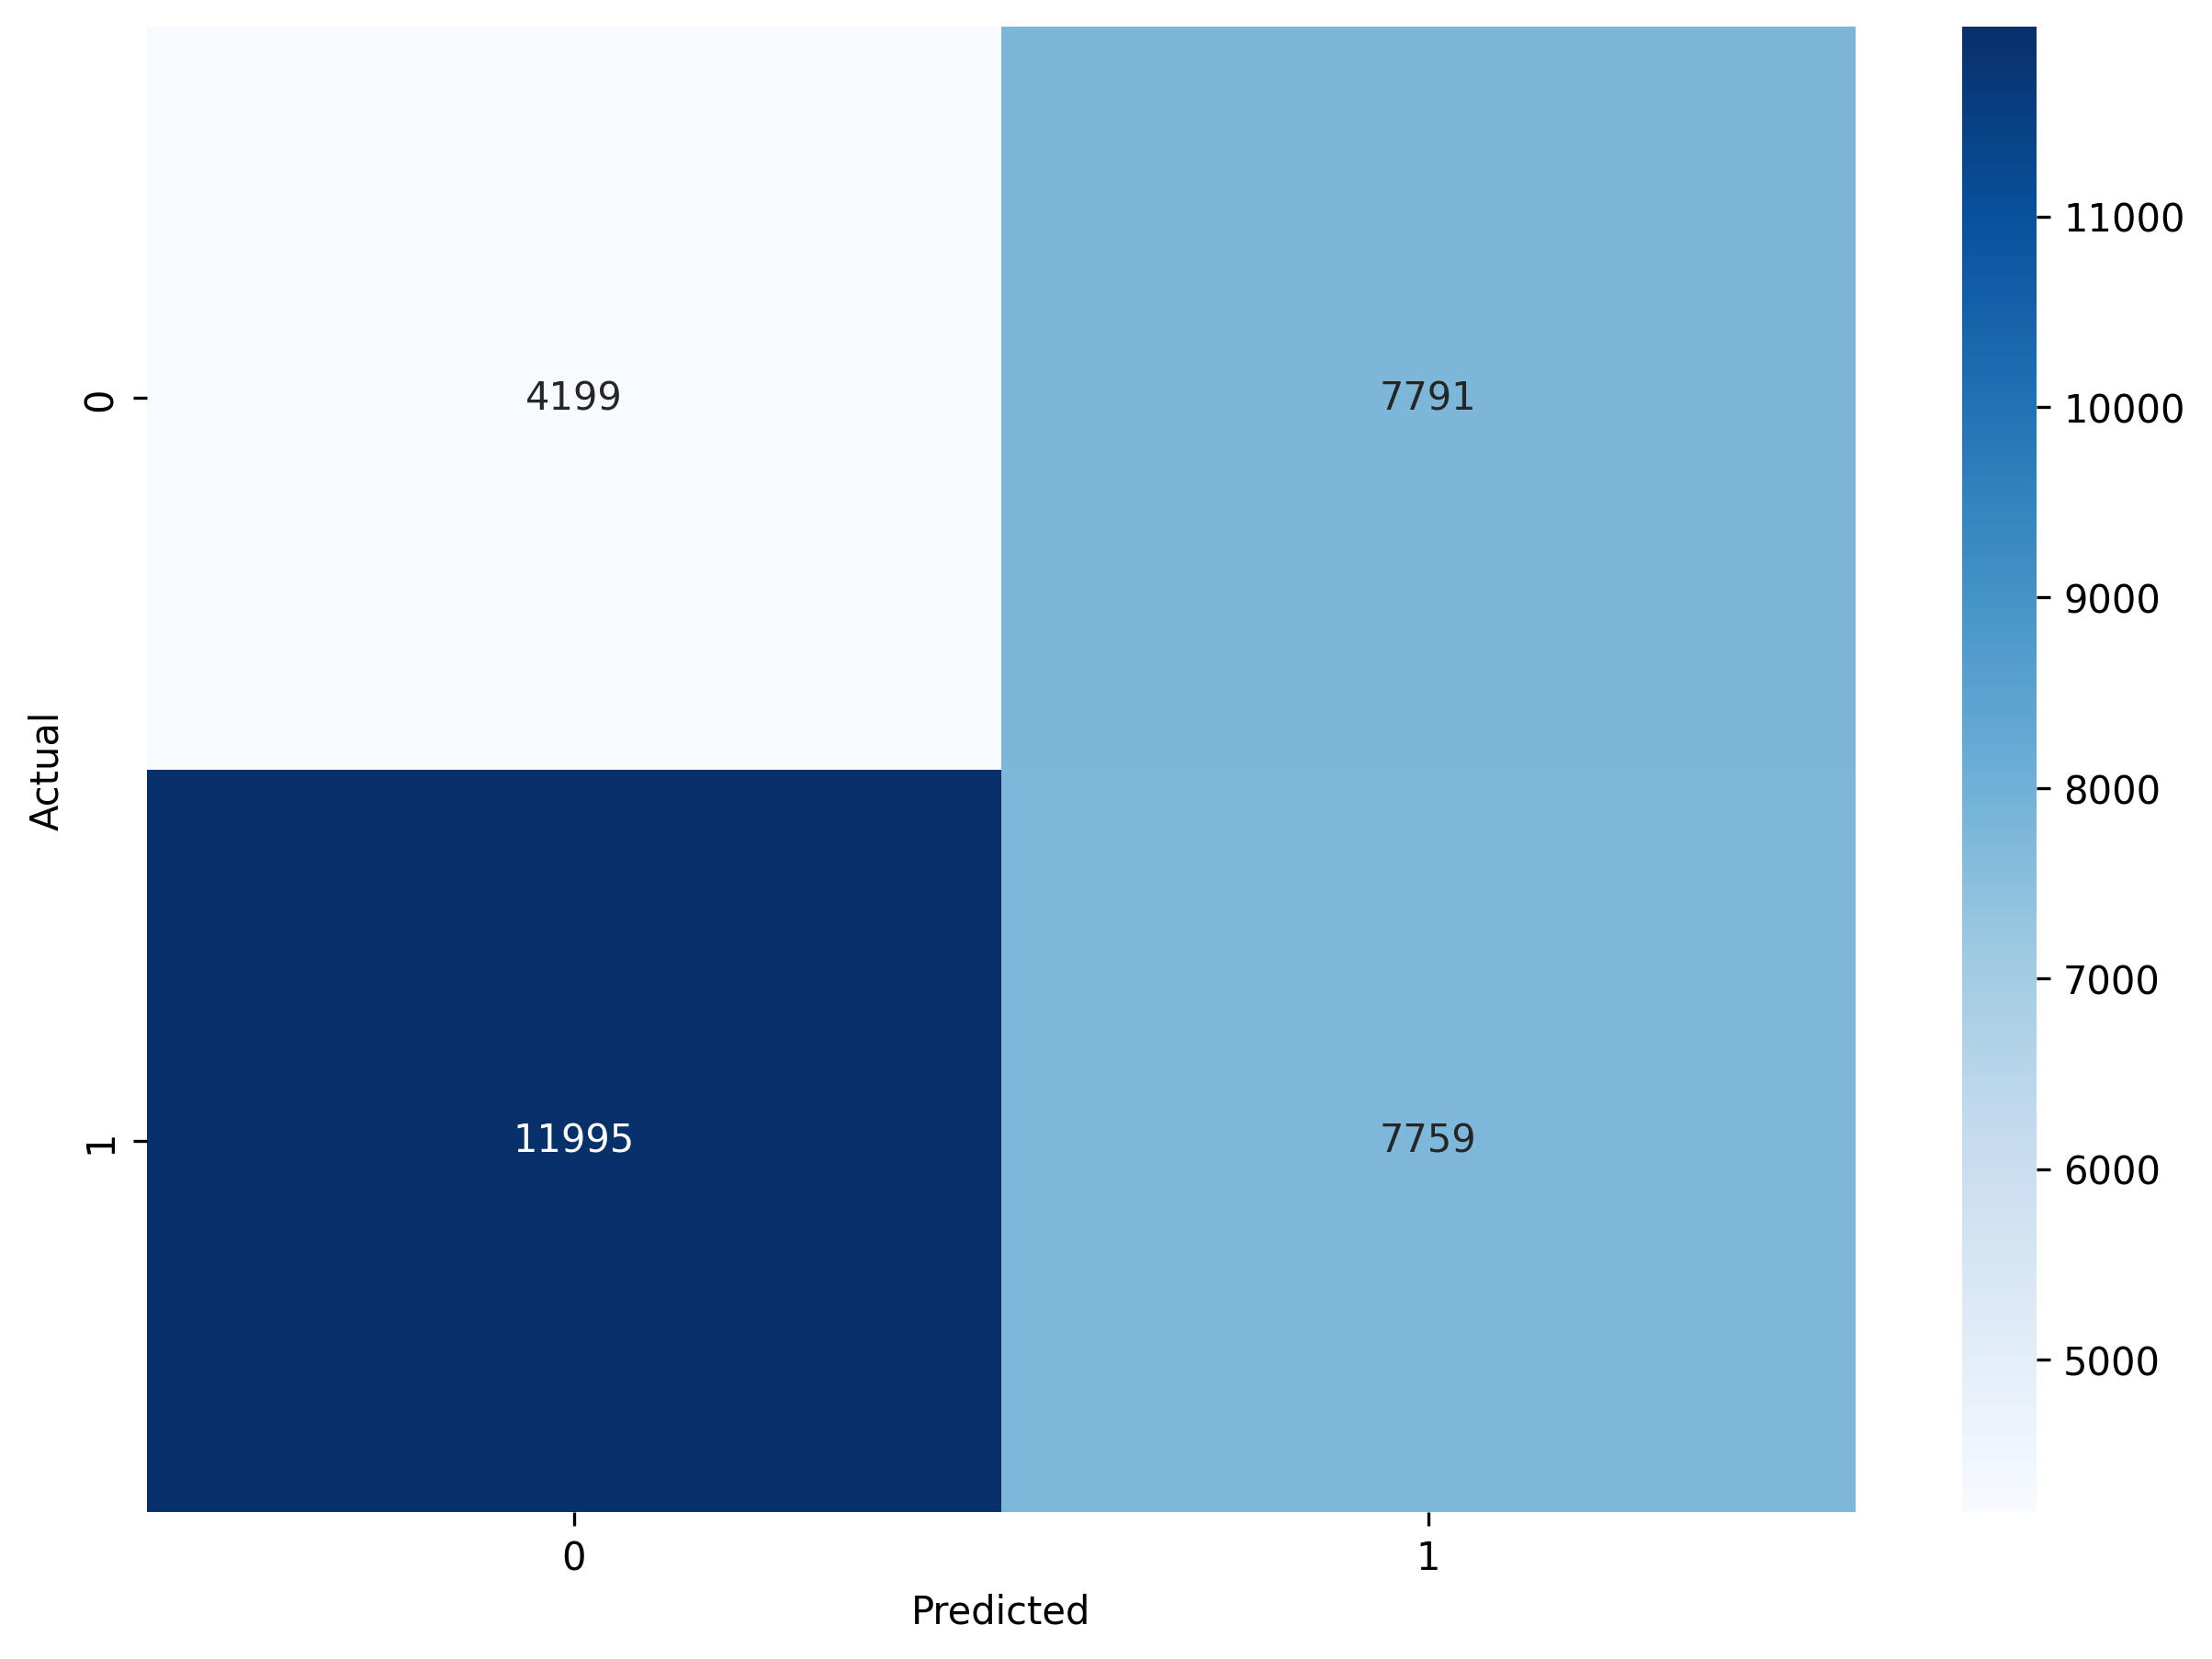

In [279]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap()
plt.figure(figsize=(10,7),dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [280]:
ticker_name_df = pd.read_csv('SP500_stock_prices.csv', delimiter=',')
# Make date column the index
ticker_name_df = ticker_name_df.set_index('Date')
# only display year, month and day in index
ticker_name_df.index = pd.to_datetime(ticker_name_df.index).date
# only keep the Ticker
ticker_name_df = ticker_name_df[['Ticker']]
# drop duplicates
ticker_name_df = ticker_name_df.drop_duplicates()
# remove the index
ticker_name_df = ticker_name_df.reset_index(drop=True)
ticker_name_df

,Ticker
0,MMM
1,AOS
2,ABT
3,ABBV
4,ACN
...,...
493,YUM
494,ZBRA
495,ZBH
496,ZION


In [281]:
test['Ticker'] = test['Ticker'].astype('category')
#  make y_pred and y_pred_proba a column in the test dataset
test['Prediction'] = y_pred
test['Prediction Probability (0)'] = y_pred_proba_test[:,0]
test['Prediction Probability (1)'] = y_pred_proba_test[:,1]
# only keep columns for ticker, target, and prediction
test = test[['Ticker', 'Target', 'Prediction', 'Prediction Probability (1)', 'Prediction Probability (0)', 'Return']]
# make the ticker column a name again

C:\Users\nicol\AppData\Local\Temp\ipykernel_19152\1012690241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Ticker'] = test['Ticker'].astype('category')
C:\Users\nicol\AppData\Local\Temp\ipykernel_19152\1012690241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = y_pred
C:\Users\nicol\AppData\Local\Temp\ipykernel_19152\1012690241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [282]:
import cvxpy as cp
import pandas as pd

def calculate_optimal_weights(test, date):
    # only keep the rows of a specific date
    # make a date be of type datetime
    date = pd.to_datetime(date)
    
    # make a new dataframe where return is the index and each column is a ticker
    return_df = test.pivot(columns='Ticker', values='Return')
    # remove stocks that have nan values in the return column
    return_df = return_df.dropna(axis=1)
    # for each ticker only keep the row of the input date
    test = test.groupby('Ticker').apply(lambda x: x.loc[x.index == date])
    test['Ticker'] = test['Ticker'].cat.remove_unused_categories()
    
    # ensure that the tickers in test are the same as the tickers in return_df
    test = test[test['Ticker'].isin(return_df.columns)]

    return_deviation = return_df.iloc[0:62]
    
    # Calculate the covariance matrix
    cov_matrix = return_deviation.cov()
    # Force the covariance matrix to be symmetric
    cov_matrix = (cov_matrix + cov_matrix.T) / 2
    
    # Number of stocks
    n = len(test['Ticker'])
    # Weights for each stock in the portfolio
    w = cp.Variable(n)
    # Objective is to minimize portfolio variance
    risk = cp.quad_form(w, cov_matrix)
    
    
    objective = cp.Minimize(risk)
   # Get the number of stocks
    n_stocks = len(test["Prediction"])

    # Get the indices of the 10 tickers with the highest predicted probabilities
    top_10_indices = test["Prediction"].nlargest(10).index

    # Constraints:
    # - weights must sum to 1
    # - only consider stocks where the SVM prediction is 1 (price will increase)
    # - expected portfolio return must be at least a certain value (e.g., 0.01)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w[test["Prediction"] == 0] == 0,
    ]

    # Only keep the 10 stocks with the highest prediction probability of increasing in price
    # Set weights for non-top 10 tickers to zero
    constraints.extend([w[i] == 0 for i in range(n_stocks) if i not in top_10_indices])

    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()



    # Get the optimal weights
    optimal_weights = w.value
    if optimal_weights is None:
        optimal_weights = np.zeros(n)
    # Create a dataframe with the optimal weights
    optimal_weights_df = pd.DataFrame(optimal_weights, index=test["Ticker"])
    # add the ticker names to the dataframe
    optimal_weights_df = optimal_weights_df.join(ticker_name_df)
    # remove the index
    optimal_weights_df = optimal_weights_df.reset_index(drop=True)
    # make the ticker the index
    optimal_weights_df = optimal_weights_df.set_index('Ticker')
    # make the column name weights
    optimal_weights_df.columns = ['Weights']

    # Sort the dataframe by the optimal weights
    optimal_weights_df = optimal_weights_df.sort_values(by=['Weights'], ascending=False)

    # Only keep the top 10 stocks and their weights, but exclude the most weighted stock
    #optimal_weights_df = optimal_weights_df.iloc[1:11]
    optimal_weights_df = optimal_weights_df.head(10)
    # normalize the weights so that they sum to 1
    optimal_weights_df['Weights'] = optimal_weights_df['Weights'] / optimal_weights_df['Weights'].sum()
    return round(optimal_weights_df,3)

In [283]:

import pandas as pd

def calculate_return(ticker, df, start_date):
    # Convert string dates to datetime
    start_date = pd.to_datetime(start_date)
    # Calculate the end date as start date + 62 trading days
    end_date = start_date + pd.tseries.offsets.BDay(63)
    # remove nan values from df
    df = df.dropna(axis=1)
    
    # Filter the dataframe for the given ticker
    df_ticker = df[df['Ticker'] == ticker]
    # Filter data between start and end dates
    mask = (df_ticker.index >= start_date) & (df_ticker.index <= end_date)
    df_ticker = df_ticker.loc[mask]
    
    # Get the opening price at the start and end dates
    start_price = df_ticker['Open'].iloc[0]
    end_price = df_ticker['Open'].iloc[-1]

    # Calculate the return
    return_percent = ((end_price - start_price) / start_price) * 100

    return round(return_percent,2)

In [286]:
def calculate_average_return(test, initial_df):
    # Initialize returns list
    returns_list = []

    # For each date in the test set
    for date in test.index.unique():
        # Calculate the optimal weights for the portfolio
        optimal_weights_df = calculate_optimal_weights(test, date)

        # Calculate the return of the portfolio
        return_list = []
        for ticker in optimal_weights_df.index:
            if optimal_weights_df.loc[ticker]['Weights'] > 0:
                # Calculate the return of the stock
                return_list.append(calculate_return(ticker, initial_df_test, date))

        # Calculate the return of the portfolio
        portfolio_return = 0
        for i in range(len(return_list)):
            portfolio_return += return_list[i] * optimal_weights_df.iloc[i]['Weights']

        # Append the return to the list
        returns_list.append(round(portfolio_return,1))
    
    # Calculate and return the average portfolio return
    return np.mean(returns_list)

In [287]:
# for each date in the test set calculate the return of the portfolio
# empty list to store the returns
returns_list = []
# for each date in the test set
for date in test.index.unique():
    # calculate the optimal weights for the portfolio
    optimal_weights_df = calculate_optimal_weights(test, date)
    print(optimal_weights_df)
    # calculate the return of the portfolio
    # for the top 10 weighted stocks in the portfolio calculate their return
    # empty list to store the returns
    return_list = []
    # for each stock in the portfolio
    for ticker in optimal_weights_df.index:
        if optimal_weights_df.loc[ticker]['Weights'] > 0:
            # calculate the return of the stock
            return_list.append(calculate_return(ticker, initial_df_test, date))
    # Calculate the return of the portfolio
    portfolio_return = 0
    for i in range(len(return_list)):
        portfolio_return += return_list[i] * optimal_weights_df.iloc[i]['Weights']
    # append the return to the list
    returns_list.append(round(portfolio_return,1))

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.208
AMZN      0.192
MO        0.160
AFL       0.128
AES       0.113
GOOG      0.080
AAP       0.044
ALGN      0.038
ADM       0.037
DXCM      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.221
AMZN      0.201
MO        0.188
AES       0.118
ADM       0.098
AMCR      0.089
ALGN      0.055
AAP       0.030
AAL       0.000
ULTA      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.221
AMZN      0.201
MO        0.188
AES       0.118
ADM       0.098
AMCR      0.089
ALGN      0.055
AAP       0.030
AAL       0.000
ULTA      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.235
AMZN      0.177
MO        0.158
AMCR      0.121
AFL       0.109
AES       0.101
ALGN      0.053
AAP       0.047
ADM       0.000
AAL       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.221
AMZN      0.201
MO        0.188
AES       0.118
ADM       0.098
AMCR      0.089
ALGN      0.055
AAP       0.030
AAL       0.000
ULTA      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.221
AMZN      0.201
MO        0.188
AES       0.118
ADM       0.098
AMCR      0.089
ALGN      0.055
AAP       0.030
AAL       0.000
ULTA      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.221
AMZN      0.201
MO        0.188
AES       0.118
ADM       0.098
AMCR      0.089
ALGN      0.055
AAP       0.030
AAL       0.000
ULTA      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.248
AMZN      0.225
MO        0.192
AES       0.130
ADM       0.129
ALGN      0.046
AAP       0.031
ALK       0.000
ILMN      0.000
DLTR      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.230
AMZN      0.213
MO        0.188
AES       0.127
ADM       0.121
GOOG      0.047
ALGN      0.044
AAP       0.030
ALK       0.000
BALL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.229
AMZN      0.213
MO        0.188
AES       0.127
ADM       0.121
GOOG      0.048
ALGN      0.044
AAP       0.030
DVN       0.000
BWA       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.230
AMZN      0.213
MO        0.188
AES       0.127
ADM       0.121
GOOG      0.047
ALGN      0.044
AAP       0.030
ALK       0.000
BALL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.236
MO        0.212
ADM       0.147
AES       0.127
GOOGL     0.112
ABT       0.069
ALGN      0.060
AAP       0.036
DXCM      0.000
PCG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.230
AMZN      0.213
MO        0.188
AES       0.127
ADM       0.121
GOOG      0.047
ALGN      0.044
AAP       0.030
ALK       0.000
BALL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.230
AMZN      0.213
MO        0.188
AES       0.127
ADM       0.121
GOOG      0.047
ALGN      0.044
AAP       0.030
ALK       0.000
BALL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.230
AMZN      0.213
MO        0.188
AES       0.127
ADM       0.121
GOOG      0.047
ALGN      0.044
AAP       0.030
ALK       0.000
BALL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.230
AMZN      0.213
MO        0.188
AES       0.127
ADM       0.121
GOOG      0.047
ALGN      0.044
AAP       0.030
ALK       0.000
BALL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.230
AMZN      0.213
MO        0.188
AES       0.127
ADM       0.121
GOOG      0.047
ALGN      0.044
AAP       0.030
ALK       0.000
BALL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.230
AMZN      0.213
MO        0.188
AES       0.127
ADM       0.121
GOOG      0.047
ALGN      0.044
AAP       0.030
ALK       0.000
BALL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.328
GOOGL     0.248
AES       0.153
ALK       0.074
AAP       0.069
ALGN      0.067
AFL       0.061
MRNA      0.000
ON        0.000
ENPH      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.292
AKAM      0.157
AES       0.132
AOS       0.118
AFL       0.094
ALGN      0.072
ADM       0.066
AAP       0.044
ALK       0.025
ALB       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.307
GOOGL     0.138
AES       0.126
AKAM      0.118
AOS       0.095
ALGN      0.064
AAP       0.046
AFL       0.045
ALK       0.031
ADM       0.030


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.246
MO        0.175
GOOGL     0.173
AFL       0.130
AES       0.114
ALGN      0.054
AAP       0.050
ADM       0.041
ALK       0.016
GOOG      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.228
AES       0.188
GOOGL     0.173
ADM       0.149
ALGN      0.082
AAP       0.054
AOS       0.051
ALK       0.040
GOOG      0.035
ALB       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.327
GOOGL     0.222
AES       0.139
ALK       0.071
AAP       0.070
ALGN      0.068
ABBV      0.057
AFL       0.046
GOOG      0.000
PCG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.234
AMZN      0.233
MO        0.194
AES       0.125
ADM       0.113
GOOG      0.053
AAP       0.037
GOOGL     0.009
CAG       0.000
TGT       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.228
AES       0.188
GOOGL     0.173
ADM       0.149
ALGN      0.082
AAP       0.054
AOS       0.051
ALK       0.040
GOOG      0.035
ALB       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.328
GOOGL     0.248
AES       0.153
ALK       0.074
AAP       0.069
ALGN      0.067
AFL       0.061
MRNA      0.000
ENPH      0.000
T         0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.352
GOOGL     0.213
AES       0.144
AOS       0.080
ALGN      0.067
AAP       0.062
ALK       0.050
AFL       0.031
ADM       0.001
ALB       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.263
MO        0.229
GOOG      0.167
ADM       0.136
AES       0.121
AAP       0.049
ABBV      0.033
GOOGL     0.000
ALB       0.000
MRNA      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AMZN      0.231
AFL       0.228
MO        0.194
AES       0.120
ADM       0.111
GOOG      0.057
AAP       0.038
ABBV      0.020
ALK       0.000
PCG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.264
GOOGL     0.188
MO        0.185
AFL       0.126
AES       0.101
AAP       0.065
ABBV      0.042
ADM       0.028
ALK       0.000
AAL       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.284
MO        0.182
GOOG      0.107
AES       0.104
AFL       0.100
AOS       0.072
GOOGL     0.067
AAP       0.054
ADM       0.030
CAG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.233
AMZN      0.233
MO        0.194
AES       0.125
ADM       0.113
GOOG      0.064
AAP       0.037
ALK       0.000
AAL       0.000
RE        0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.233
AMZN      0.233
MO        0.194
AES       0.125
ADM       0.113
GOOG      0.064
AAP       0.037
ALK       0.000
AAL       0.000
ACGL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.219
AMZN      0.208
MO        0.164
AFL       0.126
AES       0.111
GOOG      0.096
AAP       0.051
ADM       0.026
GOOGL     0.000
TGT       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.260
MO        0.168
GOOG      0.138
ADBE      0.132
AES       0.130
AFL       0.090
AAP       0.070
ADM       0.012
ALK       0.000
WDC       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.264
GOOGL     0.188
MO        0.185
AFL       0.126
AES       0.101
AAP       0.065
ABBV      0.042
ADM       0.028
ALK       0.000
PCG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.264
GOOGL     0.188
MO        0.185
AFL       0.126
AES       0.101
AAP       0.065
ABBV      0.042
ADM       0.028
ALK       0.000
GOOG      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AMZN      0.222
AFL       0.220
MO        0.194
AES       0.117
ADM       0.091
AMCR      0.064
GOOG      0.053
AAP       0.039
ALK       0.000
DHI       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.210
MO        0.207
AES       0.137
ADBE      0.135
ADM       0.114
GOOG      0.094
AAP       0.056
ABBV      0.047
GOOGL     0.000
PCG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.260
MO        0.168
GOOG      0.138
ADBE      0.132
AES       0.130
AFL       0.090
AAP       0.070
ADM       0.012
ALK       0.000
WDC       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.219
AMZN      0.208
MO        0.164
AFL       0.126
AES       0.111
GOOG      0.096
AAP       0.051
ADM       0.026
ALK       0.000
WDC       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AMZN      0.229
AFL       0.227
MO        0.194
AES       0.124
ADM       0.115
GOOG      0.058
AAP       0.035
AOS       0.018
ALK       0.000
PCG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.207
AMZN      0.201
MO        0.185
AES       0.138
ADM       0.102
ADBE      0.087
AAP       0.043
GOOG      0.037
ALK       0.000
ACGL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AMZN      0.231
AFL       0.228
MO        0.194
AES       0.120
ADM       0.111
GOOG      0.057
AAP       0.038
ABBV      0.020
ALK       0.000
PCG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AMZN      0.222
AFL       0.220
MO        0.194
AES       0.117
ADM       0.091
AMCR      0.064
GOOG      0.053
AAP       0.039
ALK       0.000
RE        0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.284
MO        0.182
GOOG      0.107
AES       0.104
AFL       0.100
AOS       0.072
GOOGL     0.067
AAP       0.054
ADM       0.030
CAG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.219
AMZN      0.208
MO        0.164
AFL       0.126
AES       0.111
GOOG      0.096
AAP       0.051
ADM       0.026
ALK       0.000
WDC       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.260
MO        0.168
GOOG      0.138
ADBE      0.132
AES       0.130
AFL       0.090
AAP       0.070
ADM       0.012
ALK       0.000
WDC       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.212
MO        0.208
AES       0.144
ADBE      0.129
ADM       0.122
GOOG      0.101
AAP       0.049
AOS       0.034
ALK       0.000
MHK       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.207
AMZN      0.201
MO        0.185
AES       0.138
ADM       0.102
ADBE      0.087
AAP       0.043
GOOG      0.037
ALK       0.000
LYV       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.316
GOOGL     0.185
AES       0.168
ADBE      0.128
AAP       0.083
ALGN      0.046
AFL       0.041
ALK       0.033
PCG       0.000
BALL      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.225
MO        0.203
AES       0.146
ADM       0.128
ADBE      0.110
GOOG      0.097
ALGN      0.046
AAP       0.045
ALK       0.000
MHK       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.260
MO        0.168
GOOG      0.138
ADBE      0.132
AES       0.130
AFL       0.090
AAP       0.070
ADM       0.012
ALK       0.000
BIIB      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.323
GOOGL     0.168
ADBE      0.159
AES       0.155
AAP       0.098
ABBV      0.065
AFL       0.026
ALK       0.006
ADM       0.000
GOOG      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.260
MO        0.168
GOOG      0.138
ADBE      0.132
AES       0.130
AFL       0.090
AAP       0.070
ADM       0.012
ALK       0.000
BIIB      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.260
MO        0.168
GOOG      0.138
ADBE      0.132
AES       0.130
AFL       0.090
AAP       0.070
ADM       0.012
ALK       0.000
BIIB      0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.213
AES       0.169
AKAM      0.148
ADBE      0.145
ADM       0.135
ABBV      0.082
AAP       0.077
ABT       0.030
ALB       0.000
ALK       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
ALL       0.325
GOOGL     0.198
AES       0.171
ADBE      0.154
AAP       0.097
AFL       0.044
ALK       0.011
ADM       0.000
GOOG      0.000
ALB       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.256
MO        0.229
GOOG      0.161
ADM       0.143
AES       0.126
AOS       0.043
AAP       0.042
ALK       0.000
A         0.000
NVR       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.233
AMZN      0.233
MO        0.194
AES       0.125
ADM       0.113
GOOG      0.064
AAP       0.037
ALK       0.000
AAL       0.000
RE        0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.233
AMZN      0.233
MO        0.194
AES       0.125
ADM       0.113
GOOG      0.064
AAP       0.037
ALK       0.000
AAL       0.000
RE        0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.207
AMZN      0.201
MO        0.185
AES       0.138
ADM       0.102
ADBE      0.087
AAP       0.043
GOOG      0.037
GOOGL     0.000
PCG       0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


        Weights
Ticker         
AFL       0.233
AMZN      0.233
MO        0.194
AES       0.125
ADM       0.113
GOOG      0.064
AAP       0.037
ALK       0.000
AAL       0.000
RE        0.000


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [118]:
# Make a dataframe with the returns and dates
returns_df = pd.DataFrame(returns_list, index=test.index.unique())
# make the column name returns
returns_df.columns = ['SVM Portfolio 3-month Returns (%)']
returns_df

,SVM Portfolio 3-month Returns (%)
2019-10-01,11.6
2019-10-02,14.9
2019-10-03,16.0
2019-10-04,13.4
2019-10-07,14.8
...,...
2019-12-24,-33.6
2019-12-26,-27.4
2019-12-27,-27.5
2019-12-30,-22.4


In [119]:
# average return of the portfolio
print(f"Average return of the portfolio: {np.mean(returns_list)}")
# print the standard deviation of the returns
print(f"Standard deviation of the returns: {np.std(returns_list)}")
# print number of days the portfolio had a positive return
print(f"Number of days the portfolio had a positive return: {len([i for i in returns_list if i > 0])}")
print(f"Number of days the portfolio had a negative return: {len([i for i in returns_list if i < 0])}")

Average return of the portfolio: -0.19531250000000022
Standard deviation of the returns: 14.24072537749899
Number of days the portfolio had a positive return: 42
Number of days the portfolio had a negative return: 22


In [170]:
# read in the csv file for svm_portfolio_returns_gamma=10
svm_portfolio_returns_gamma_10 = pd.read_csv('svm_portfolio_returns_gamma_10.csv',index_col=0)
svm_portfolio_returns_gamma_10


,SVM Portfolio 3-month Returns (%) gamma = 10
2019-10-01,7.0
2019-10-02,9.6
2019-10-03,9.0
2019-10-04,11.0
2019-10-07,11.2
...,...
2019-12-24,-22.8
2019-12-26,-28.6
2019-12-27,-24.8
2019-12-30,-27.2


In [173]:
# perform wilcoxon signed rank test on the two portfolios to determine if they are significantly different
from scipy.stats import wilcoxon

# Pairwise comparison for SVM vs S&P 500
stat, p = wilcoxon(returns_df,svm_portfolio_returns_gamma_10)
print('Statistics=%.3f, p=%.7f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('SVM (gamma = default) vs SVM (gamma = 10): Same distribution (fail to reject H0)')
else:
    print('SVM (gamma = default) vs SVM (gamma = 10): Different distribution (reject H0)')

Statistics=594.000, p=0.0028568
SVM (gamma = default) vs SVM (gamma = 10): Different distribution (reject H0)


In [175]:
# calculate the average return of the two portfolios and their standard deviation
svm_portfolio_returns_gamma_10_mean = np.mean(svm_portfolio_returns_gamma_10)
svm_portfolio_returns_gamma_10_std = np.std(svm_portfolio_returns_gamma_10)
print(f"Average return of the SVM portfolio (gamma = 10): {svm_portfolio_returns_gamma_10_mean}")
print(f"Standard deviation of the SVM portfolio (gamma = 10): {svm_portfolio_returns_gamma_10_std}")


returns_df_mean = np.mean(returns_df)
returns_df_std = np.std(returns_df)
print(f"Average return of the SVM portfolio (gamma = default): {returns_df_mean}")
print(f"Standard deviation of the SVM portfolio (gamma = default): {returns_df_std}")



Average return of the SVM portfolio (gamma = 10): SVM Portfolio 3-month Returns (%) gamma = 10   -1.514063
dtype: float64
Standard deviation of the SVM portfolio (gamma = 10): SVM Portfolio 3-month Returns (%) gamma = 10    12.367408
dtype: float64
Average return of the SVM portfolio (gamma = default): SVM Portfolio 3-month Returns (%)   -0.195313
dtype: float64
Standard deviation of the SVM portfolio (gamma = default): SVM Portfolio 3-month Returns (%)    14.240725
dtype: float64


In [219]:
# Comparing the SVM portfolio with its SVM PE-Ratio counterpart
# read in the csv file for svm_portfolio_returns_pe
svm_portfolio_returns_pe_ratio = pd.read_csv('svm_portfolio_returns_pe.csv',index_col=0)
svm_portfolio_returns_pe_ratio

,SVM Portfolio 3-month Returns (%) with PE-Ratio
2019-10-01,15.8
2019-10-02,14.8
2019-10-03,16.0
2019-10-04,14.9
2019-10-07,14.5
...,...
2019-12-24,-20.6
2019-12-26,-26.8
2019-12-27,-28.2
2019-12-30,-22.4


In [221]:
# perform wilcoxon signed rank test on the two portfolios to determine if they are significantly different
from scipy.stats import wilcoxon

# Pairwise comparison for SVM vs S&P 500
stat, p = wilcoxon(returns_df,svm_portfolio_returns_pe_ratio)
print('Statistics=%.3f, p=%.7f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('SVM vs SVM with PE-Ratio Included: Same distribution (fail to reject H0)')
else:
    print('SVM vs SVM with PE-Ratio Included: Different distribution (reject H0)')

Statistics=857.000, p=0.6693685
SVM vs SVM with PE-Ratio Included: Same distribution (fail to reject H0)


In [222]:
# calculate the average return of the two portfolios and their standard deviation
svm_portfolio_returns_pe_mean = np.mean(svm_portfolio_returns_pe_ratio)
svm_portfolio_returns_std = np.std(svm_portfolio_returns_pe_ratio)
print(f"Average return of the SVM portfolio with PE-Ratio included: {svm_portfolio_returns_pe_mean}")
print(f"Standard deviation of the SVM portfolio with PE-Ratio included: {svm_portfolio_returns_std}")


returns_df_mean = np.mean(returns_df)
returns_df_std = np.std(returns_df)
print(f"Average return of the SVM portfolio: {returns_df_mean}")
print(f"Standard deviation of the SVM portfolio: {returns_df_std}")


Average return of the SVM portfolio with PE-Ratio included: SVM Portfolio 3-month Returns (%) with PE-Ratio    0.073437
dtype: float64
Standard deviation of the SVM portfolio with PE-Ratio included: SVM Portfolio 3-month Returns (%) with PE-Ratio    13.551179
dtype: float64
Average return of the SVM portfolio: SVM Portfolio 3-month Returns (%)   -0.195313
dtype: float64
Standard deviation of the SVM portfolio: SVM Portfolio 3-month Returns (%)    14.240725
dtype: float64


In [223]:
# Make a dataframe with the returns and dates
returns_df = pd.DataFrame(returns_list, index=test.index.unique())
# make the column name returns
returns_df.columns = ['SVM Portfolio 3-month Returns (%)']
returns_df

,SVM Portfolio 3-month Returns (%)
2019-10-01,11.6
2019-10-02,14.9
2019-10-03,16.0
2019-10-04,13.4
2019-10-07,14.8
...,...
2019-12-24,-33.6
2019-12-26,-27.4
2019-12-27,-27.5
2019-12-30,-22.4


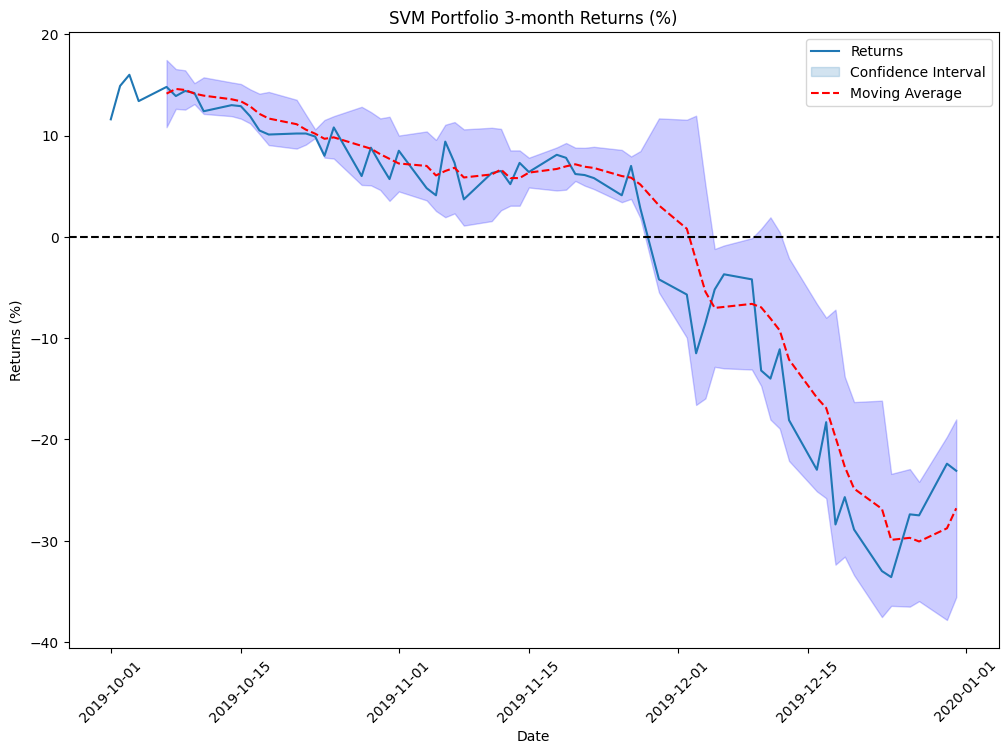

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt
moving_average = returns_df.rolling(window=5).mean()
moving_variance = returns_df.rolling(window=5).std()
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.lineplot(data=returns_df, x=returns_df.index, y='SVM Portfolio 3-month Returns (%)')
# make moving average line
plt.plot(moving_average, color='r', linestyle='--')
# make confidence interval shaded area
plt.fill_between(moving_variance.index, moving_average['SVM Portfolio 3-month Returns (%)'] - 1.96 * moving_variance['SVM Portfolio 3-month Returns (%)'], moving_average['SVM Portfolio 3-month Returns (%)'] + 1.96 * moving_variance['SVM Portfolio 3-month Returns (%)'], alpha=0.2, color='b')
plt.title('SVM Portfolio 3-month Returns (%)')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
# plot legend in the upper right corner for returns, moving average and confidence interval
plt.legend(['Returns', 'Confidence Interval', 'Moving Average'], loc='upper right')
# make 0 horizontal line
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

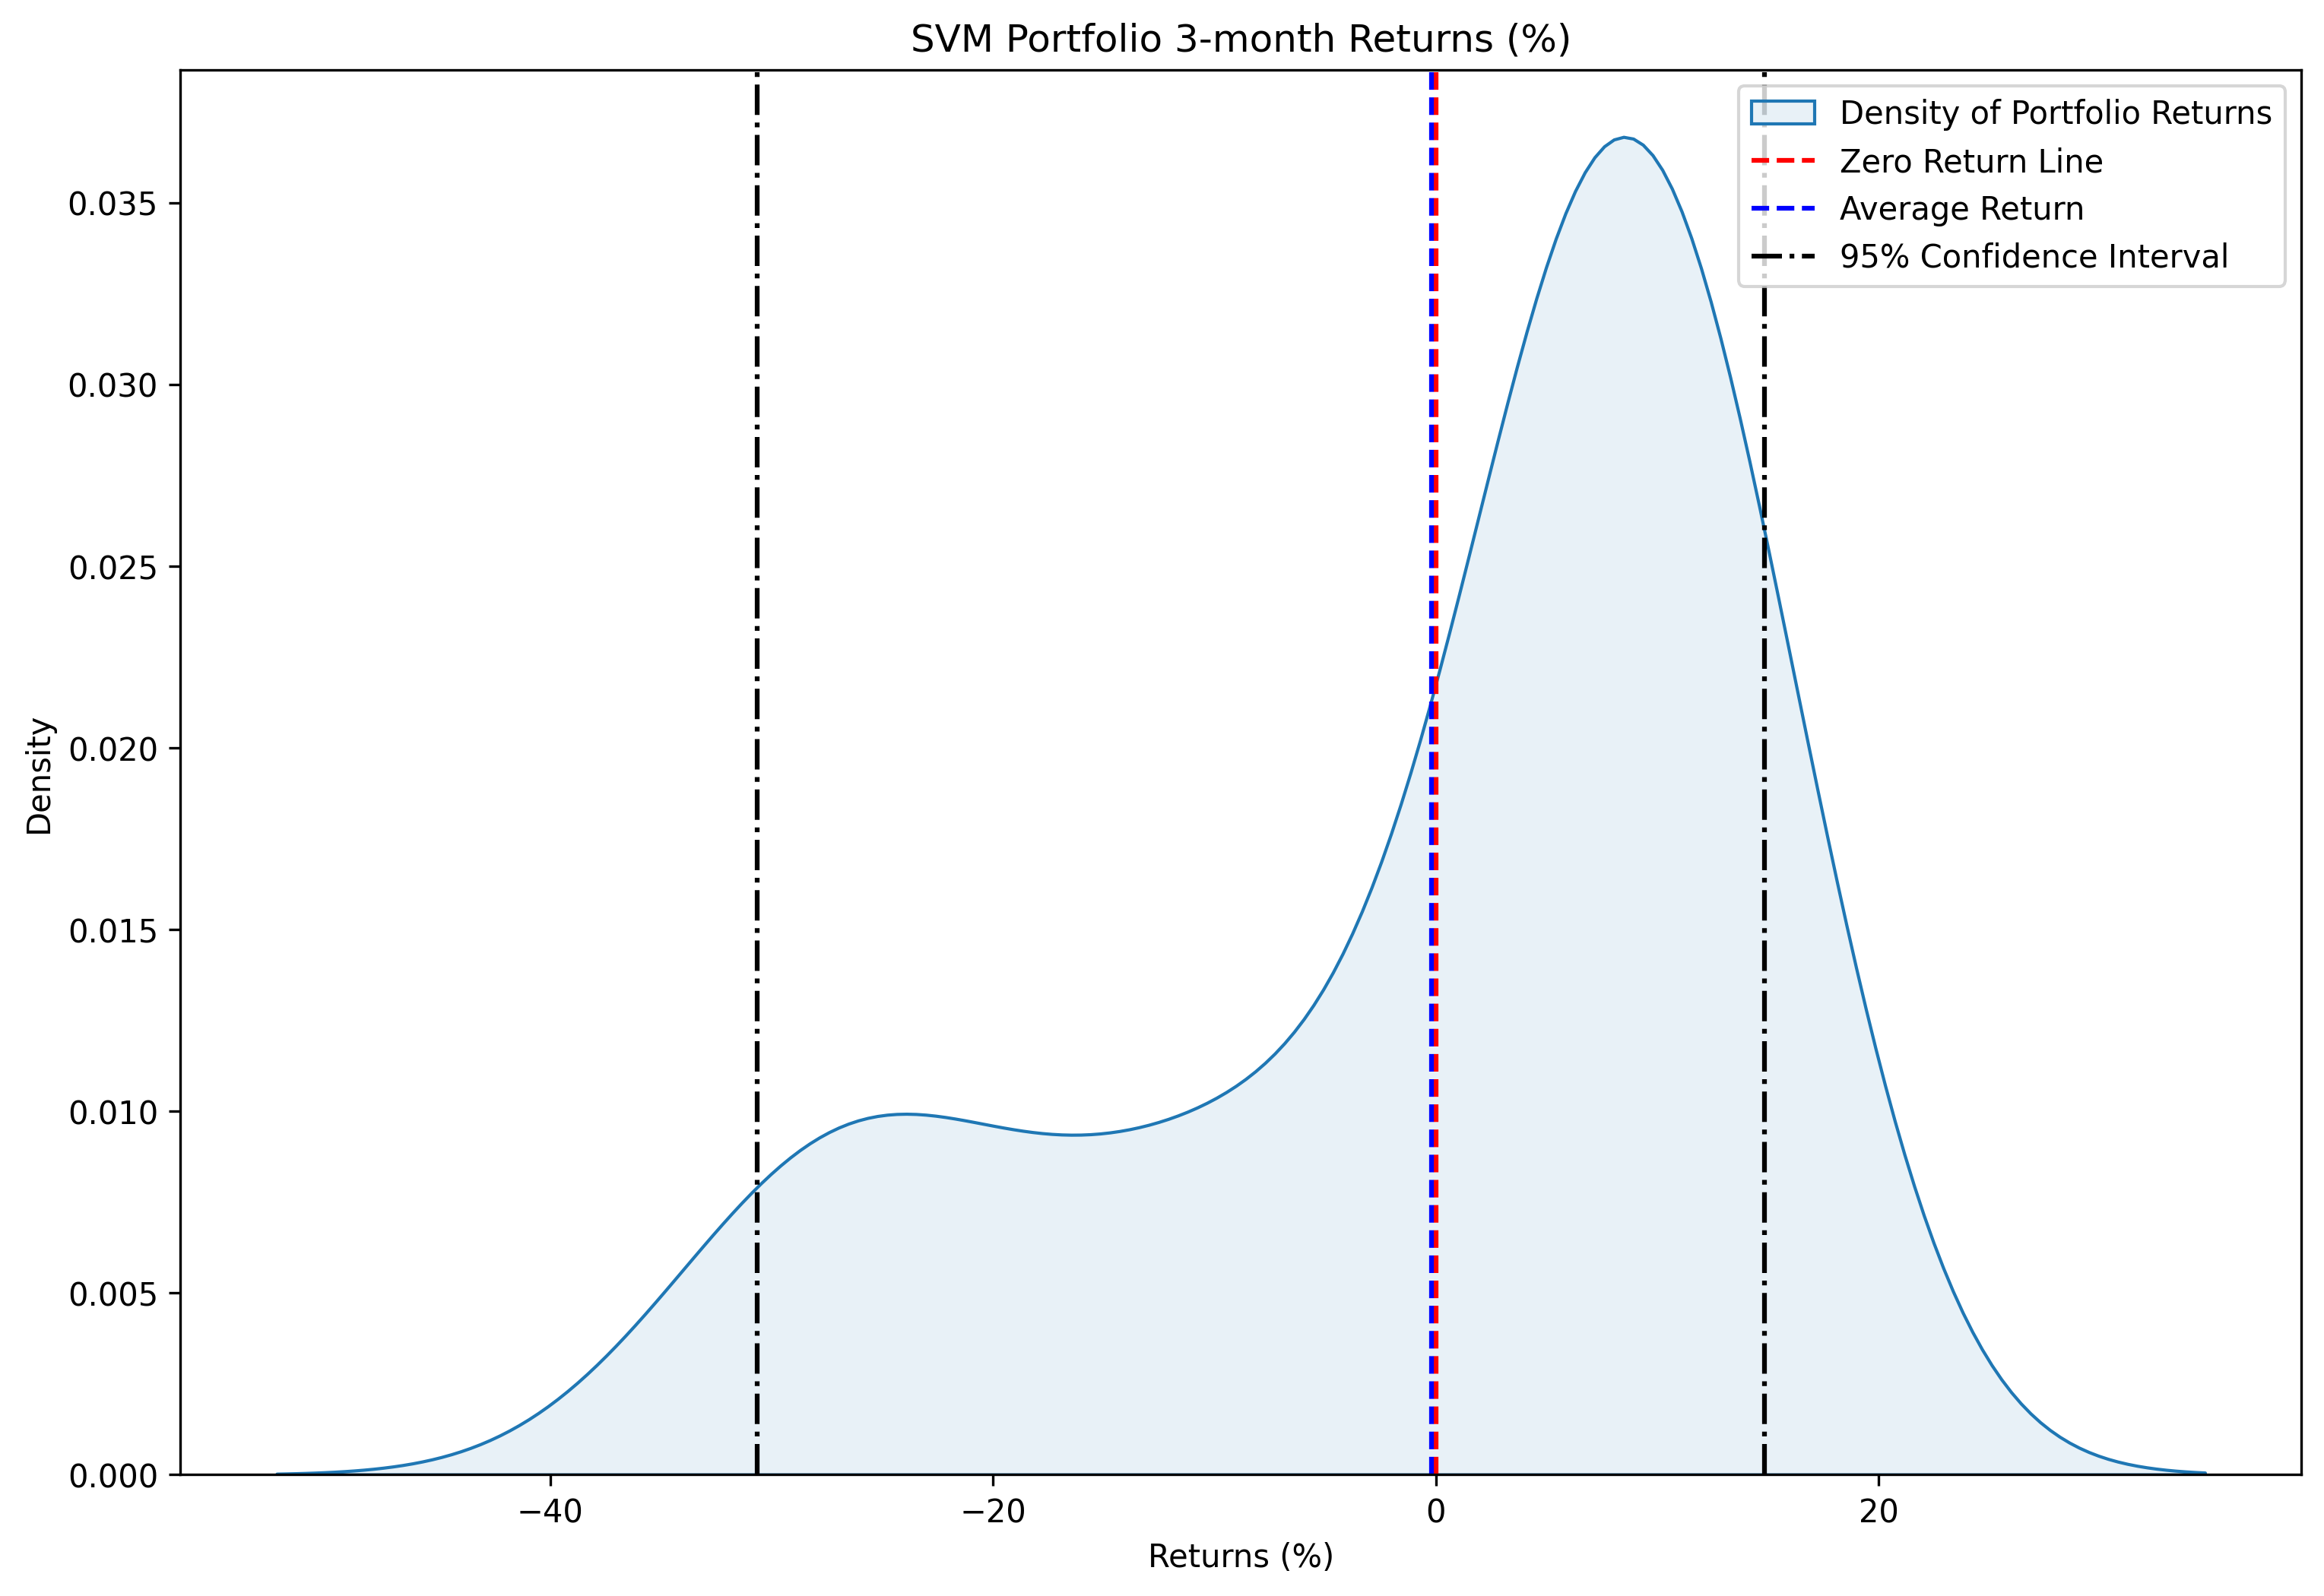

In [122]:
# make density plot of the returns
plt.figure(figsize=(12,8), facecolor='white', dpi=300)
sns.kdeplot(data=returns_df, x='SVM Portfolio 3-month Returns (%)', fill=True, alpha=0.1)
# make 0 vertical line
plt.axvline(x=0, color='r', linestyle='--')
# make average return vertical line
plt.axvline(x=returns_df['SVM Portfolio 3-month Returns (%)'].mean(), color='b', linestyle='--')
# include confindence interval vertical lines
lower_bound = np.quantile(returns_df['SVM Portfolio 3-month Returns (%)'], 0.025)
upper_bound = np.quantile(returns_df['SVM Portfolio 3-month Returns (%)'], 0.975)
plt.axvline(x=lower_bound, color='black', linestyle='dashdot')
plt.axvline(x=upper_bound, color='black', linestyle='dashdot')
plt.legend(['Density of Portfolio Returns','Zero Return Line', 'Average Return', '95% Confidence Interval'], loc='upper right')
plt.title('SVM Portfolio 3-month Returns (%)')
plt.ylabel('Density')
plt.xlabel('Returns (%)')
plt.show()


In [124]:
# average return
print('Average return:', round(returns_df.mean()[0],3))

Average return: -0.195


In [125]:
# show the 10 days with the most return
returns_df.sort_values(by=['SVM Portfolio 3-month Returns (%)'], ascending=False).head(10)


,SVM Portfolio 3-month Returns (%)
2019-10-03,16.0
2019-10-02,14.9
2019-10-07,14.8
2019-10-09,14.4
2019-10-10,14.2
2019-10-08,13.9
2019-10-04,13.4
2019-10-14,13.0
2019-10-15,12.9
2019-10-11,12.4


In [225]:
# show the 10 days with the least return
returns_df.sort_values(by=['SVM Portfolio 3-month Returns (%)'], ascending=True).head(10)

,SVM Portfolio 3-month Returns (%)
2019-12-24,-33.6
2019-12-23,-33.0
2019-12-20,-28.9
2019-12-18,-28.4
2019-12-27,-27.5
2019-12-26,-27.4
2019-12-19,-25.7
2019-12-31,-23.1
2019-12-16,-23.0
2019-12-30,-22.4


## S&P 500 Returns in the same time period

In [127]:
import yfinance as yf
from pandas_datareader import data as pdr
# This line is needed to fix a problem with pandas_datareader
yf.pdr_override()

start_date = '2019-10-01'
end_date = '2020-04-02'
# 
# Get data from Yahoo Finance
sp500 = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
# we are only interested in the open price
sp500 = sp500['Close']
# Transform it into a dataframe
sp500_returns = pd.DataFrame(sp500)
# Make 'S&P 500 Index Price' the column header
sp500_returns = sp500_returns.rename(columns={'Close': 'S&P 500 Index Price'})
# Calculate the 3 month return for each day
sp500_returns['S&P 500 - 3 Month Return (%)'] = sp500_returns['S&P 500 Index Price'].pct_change(periods=63).shift(-63)
# calculating all 3-month return values by 100 to obtain percent
sp500_returns['S&P 500 - 3 Month Return (%)'] = sp500_returns['S&P 500 - 3 Month Return (%)'] * 100
sp500_returns.round(2)
# remove the S&P 500 Index Price column
sp500_returns = sp500_returns.drop(columns=['S&P 500 Index Price'])
# removing all rows with NaN values (The last 62 days, since they don't have data for 3 months into the future)
sp500_returns = sp500_returns.dropna()
sp500_returns

[*********************100%***********************]  1 of 1 completed


,S&P 500 - 3 Month Return (%)
Date,
2019-10-01,9.881134
2019-10-02,12.821675
2019-10-03,11.139177
2019-10-04,9.968463
2019-10-07,10.153495
...,...
2019-12-24,-18.406450
2019-12-26,-21.557388
2019-12-27,-18.931059


__Random Monkey__

In [149]:
# add the returns of random monkey model as a new column
random_monkey_returns = pd.read_csv('random_monkey_portfolio_returns.csv', index_col=0)
# make random monkey index as datetime
random_monkey_returns.index = pd.to_datetime(random_monkey_returns.index)

In [155]:
# Combine the returns of the portfolio and the S&P 500
combined_returns = pd.concat([returns_df, sp500_returns], axis='columns', join='inner')
combined_returns.round(1)
# add a new column that shows the Random Monkey returns
combined_returns['Random Monkey 63-day Returns (%)'] = random_monkey_returns['Random Monkey - 3 Month Return (%)'].copy()
round(combined_returns,1)

,SVM Portfolio 3-month Returns (%),S&P 500 - 3 Month Return (%),Random Monkey 63-day Returns (%)
2019-10-01,11.6,9.9,4.6
2019-10-02,14.9,12.8,19.1
2019-10-03,16.0,11.1,14.4
2019-10-04,13.4,10.0,9.0
2019-10-07,14.8,10.2,9.8
...,...,...,...
2019-12-24,-33.6,-18.4,-23.7
2019-12-26,-27.4,-21.6,-26.8
2019-12-27,-27.5,-18.9,-18.4
2019-12-30,-22.4,-19.8,-36.5


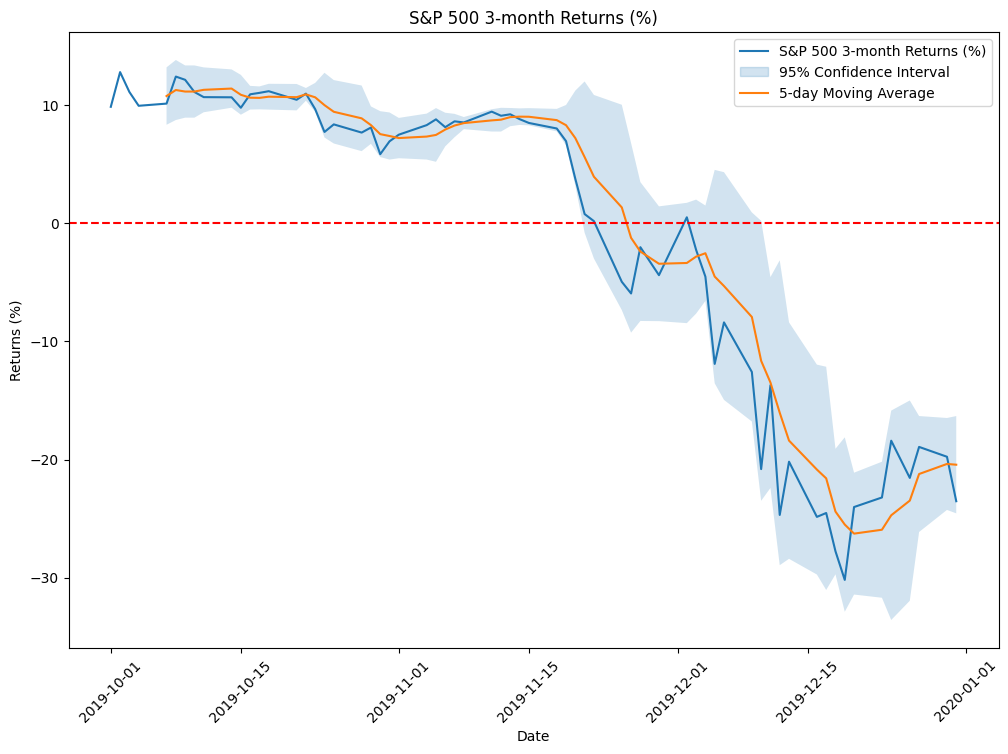

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
# make the plot for the S&P 500 returns
# moving average
combined_returns['S&P 500 - 3 Month Return (%) - Moving Average'] = combined_returns['S&P 500 - 3 Month Return (%)'].rolling(window=5).mean()
# moving standard deviation
combined_returns['S&P 500 - 3 Month Return (%) - Moving Standard Deviation'] = combined_returns['S&P 500 - 3 Month Return (%)'].rolling(window=5).std()
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%)')
# include moving average line
sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%) - Moving Average')
# include the 0 horizontal line
plt.axhline(y=0, color='r', linestyle='--')
# include shaded area for the moving average confidence interval
plt.fill_between(combined_returns.index, combined_returns['S&P 500 - 3 Month Return (%) - Moving Average'] - 1.96 * combined_returns['S&P 500 - 3 Month Return (%) - Moving Standard Deviation'], combined_returns['S&P 500 - 3 Month Return (%) - Moving Average'] + 1.96 * combined_returns['S&P 500 - 3 Month Return (%) - Moving Standard Deviation'], alpha=0.2)
plt.title('S&P 500 3-month Returns (%)')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(['S&P 500 3-month Returns (%)', '95% Confidence Interval','5-day Moving Average'], loc='upper right')
plt.show()

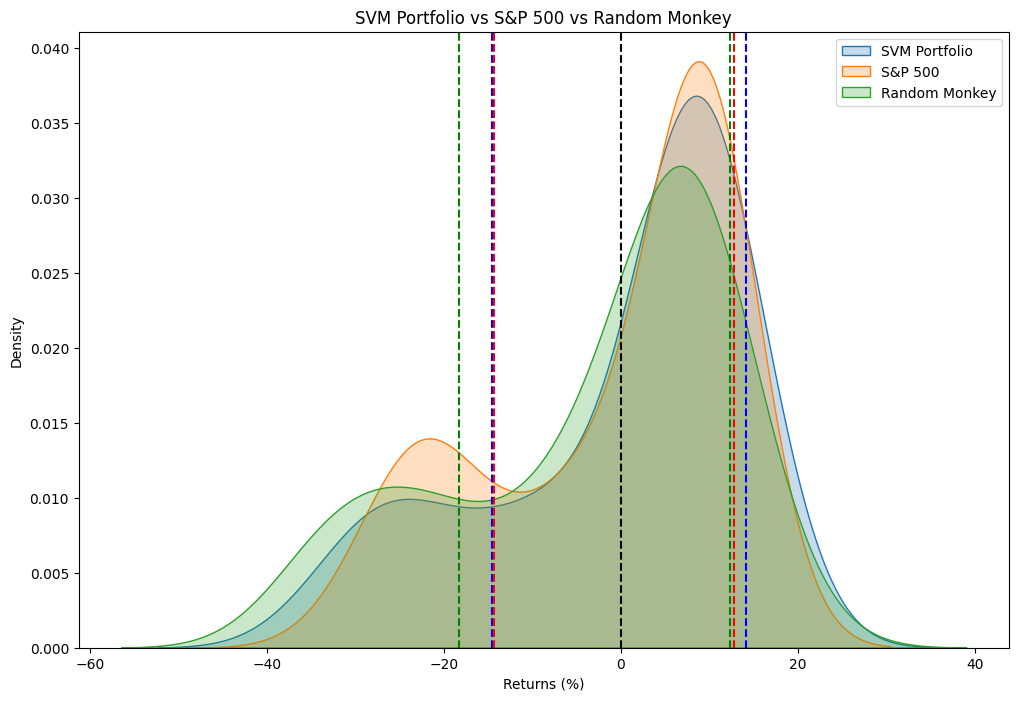

In [152]:
# make density plot for the three returns
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.kdeplot(data=combined_returns, x='SVM Portfolio 3-month Returns (%)', fill=True, label='SVM Portfolio')
sns.kdeplot(data=combined_returns, x='S&P 500 - 3 Month Return (%)', fill=True, label='S&P 500')
sns.kdeplot(data=combined_returns, x='Random Monkey 63-day Returns (%)', fill=True, label='Random Monkey')
# confidence interval for the portfolios
plt.axvline(x=combined_returns['SVM Portfolio 3-month Returns (%)'].mean() + combined_returns['SVM Portfolio 3-month Returns (%)'].std(), color='b', linestyle='--')
plt.axvline(x=combined_returns['SVM Portfolio 3-month Returns (%)'].mean() - combined_returns['SVM Portfolio 3-month Returns (%)'].std(), color='b', linestyle='--')
# confidence interval for the S&P 500
plt.axvline(x=combined_returns['S&P 500 - 3 Month Return (%)'].mean() + combined_returns['S&P 500 - 3 Month Return (%)'].std(), color='r', linestyle='--')
plt.axvline(x=combined_returns['S&P 500 - 3 Month Return (%)'].mean() - combined_returns['S&P 500 - 3 Month Return (%)'].std(), color='r', linestyle='--')
# confidence interval for the Random Monkey
plt.axvline(x=combined_returns['Random Monkey 63-day Returns (%)'].mean() + combined_returns['Random Monkey 63-day Returns (%)'].std(), color='g', linestyle='--')
plt.axvline(x=combined_returns['Random Monkey 63-day Returns (%)'].mean() - combined_returns['Random Monkey 63-day Returns (%)'].std(), color='g', linestyle='--')
plt.title('SVM Portfolio vs S&P 500 vs Random Monkey')
# make 0 vertical line
plt.axvline(x=0, color='black', linestyle='--')
# make legend
plt.legend()
plt.ylabel('Density')
plt.xlabel('Returns (%)')
plt.show()

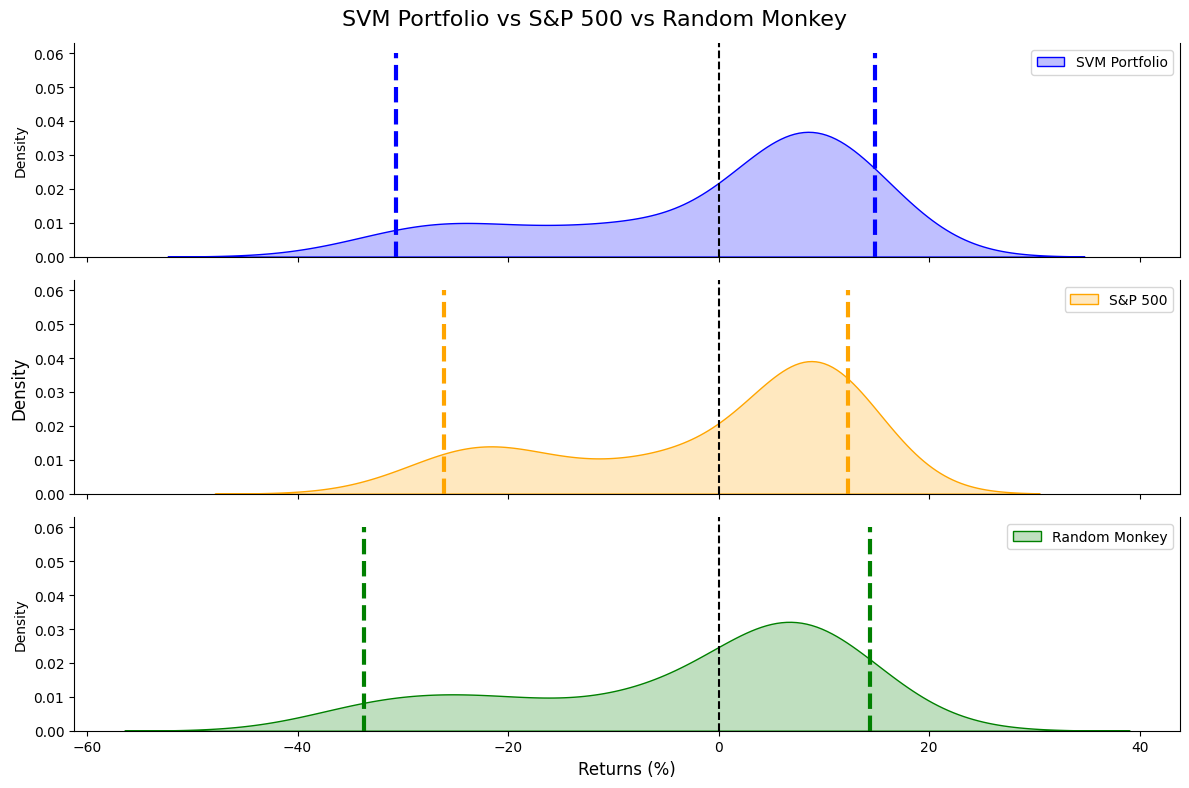

In [153]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True, dpi=100)

# Define labels and columns
labels = ['SVM Portfolio', 'S&P 500', 'Random Monkey']
columns = ['SVM Portfolio 3-month Returns (%)', 'S&P 500 - 3 Month Return (%)', 'Random Monkey 63-day Returns (%)']
colors = ['blue', 'orange', 'green']

# Iterate over labels, columns and axes simultaneously
for label, column, color, ax in zip(labels, columns, colors, axes):
    # Make density plot
    sns.kdeplot(data=combined_returns, x=column, fill=True, ax=ax, label=label, color=color)

    # Draw vertical lines for the confidence intervals
    # confidence interval quantiles
    ci_lower = np.quantile(combined_returns[column], 0.025)
    ci_upper = np.quantile(combined_returns[column], 0.975)
    ax.plot([ci_lower, ci_lower], [0, 0.06], color=color, linestyle='--', linewidth=3)
    ax.plot([ci_upper, ci_upper], [0, 0.06], color=color, linestyle='--', linewidth=3)
    
    # Add zero line
    ax.axvline(x=0, color='black', linestyle='--')
    # remove box around plot
    ax.spines['top'].set_visible(False)
    # Set title and legend
    #ax.set_title(label)
    ax.legend()
# make title for entire plot
fig.suptitle('SVM Portfolio vs S&P 500 vs Random Monkey', fontsize=16)
# Set common labels
axes[1].set_ylabel('Density', fontsize=12)
axes[2].set_xlabel('Returns (%)', fontsize=12)

plt.tight_layout()
plt.show()

In [156]:
# average return of each column
average_return = combined_returns.mean()
average_return

SVM Portfolio 3-month Returns (%)   -0.195313
S&P 500 - 3 Month Return (%)        -0.741450
Random Monkey 63-day Returns (%)    -2.981250
dtype: float64

In [157]:
# standard deviation of each column
standard_deviation = combined_returns.std()
standard_deviation

SVM Portfolio 3-month Returns (%)    14.353302
S&P 500 - 3 Month Return (%)         13.530569
Random Monkey 63-day Returns (%)     15.286293
dtype: float64

In [158]:
# 95% confidence interval of each column
confidence_interval = combined_returns.quantile([0.025, 0.975])
confidence_interval

,SVM Portfolio 3-month Returns (%),S&P 500 - 3 Month Return (%),Random Monkey 63-day Returns (%)
0.025,-30.6425,-26.096485,-33.6550
0.975,14.8425,12.286300,14.3425


In [159]:
# calculate median of each column
median = combined_returns.median()
median

SVM Portfolio 3-month Returns (%)    6.150000
S&P 500 - 3 Month Return (%)         7.609881
Random Monkey 63-day Returns (%)     3.750000
dtype: float64

__Non_Parametric Statistical Tests__

In [160]:
import numpy as np
from scipy.stats import friedmanchisquare

# let's assume these are your 3-month returns for each model
svm_returns = combined_returns['SVM Portfolio 3-month Returns (%)']
sp500_returns = combined_returns['S&P 500 - 3 Month Return (%)']
random_monkey_returns = combined_returns['Random Monkey 63-day Returns (%)']
# apply Friedman test
stat, p = friedmanchisquare(svm_returns, sp500_returns, random_monkey_returns)

print('Statistics=%.3f, p=%.7f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=16.969, p=0.0002067
Different distributions (reject H0)


In [226]:
from scipy.stats import wilcoxon

# Pairwise comparison for SVM vs S&P 500
stat, p = wilcoxon(svm_returns, sp500_returns)
print('Statistics=%.3f, p=%.7f' % (stat, p))
if p > alpha:
    print('SVM vs SP500: Same distribution (fail to reject H0)')
else:
    print('SVM vs SP500: Different distribution (reject H0)')

# Pairwise comparison for SVM vs Random Monkey
stat, p = wilcoxon(svm_returns, random_monkey_returns)
print('\nStatistics=%.3f, p=%.7f' % (stat, p))
if p > alpha:
    print('SVM vs Random Monkey: Same distribution (fail to reject H0)')
else:
    print('SVM vs Random Monkey: Different distribution (reject H0)')

# Pairwise comparison for S&P 500 vs Random Monkey
stat, p = wilcoxon(sp500_returns, random_monkey_returns)
print('\nStatistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('SP500 vs Random Monkey: Same distribution (fail to reject H0)')
else:
    print('SP500 vs Random Monkey: Different distribution (reject H0)')

Statistics=874.000, p=0.2669448
SVM vs SP500: Same distribution (fail to reject H0)

Statistics=526.000, p=0.0005871
SVM vs Random Monkey: Different distribution (reject H0)

Statistics=522.000, p=0.001
SP500 vs Random Monkey: Different distribution (reject H0)


In [227]:
# The sign test, which does not assume that the distributions are symmetrical
from scipy import stats

# Calculate differences for each pair of portfolios
diff_svm_sp500 = svm_returns - sp500_returns
diff_svm_random = svm_returns - random_monkey_returns
diff_sp500_random = sp500_returns - random_monkey_returns


# Perform Sign test
p_value_svm_sp500 = stats.binom_test((diff_svm_sp500 > 0).sum(), n=len(diff_svm_sp500), alternative='two-sided')
p_value_svm_random = stats.binom_test((diff_svm_random > 0).sum(), n=len(diff_svm_random), alternative='two-sided')
p_value_sp500_random = stats.binom_test((diff_sp500_random > 0).sum(), n=len(diff_sp500_random), alternative='two-sided')

print(f"p-value for the difference between SVM portfolio and SP500: {p_value_svm_sp500}")
print(f"p-value for the difference between SVM portfolio and Random portfolio: {p_value_svm_random}")
print(f"p-value for the difference between SP500 and Random portfolio: {p_value_sp500_random}")

p-value for the difference between SVM portfolio and SP500: 0.16864291143970336
p-value for the difference between SVM portfolio and Random portfolio: 0.0015627893448280279
p-value for the difference between SP500 and Random portfolio: 0.0015627893448280279


C:\Users\nicol\AppData\Local\Temp\ipykernel_19152\1339430160.py:11: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value_svm_sp500 = stats.binom_test((diff_svm_sp500 > 0).sum(), n=len(diff_svm_sp500), alternative='two-sided')
C:\Users\nicol\AppData\Local\Temp\ipykernel_19152\1339430160.py:12: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value_svm_random = stats.binom_test((diff_svm_random > 0).sum(), n=len(diff_svm_random), alternative='two-sided')
C:\Users\nicol\AppData\Local\Temp\ipykernel_19152\1339430160.py:13: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value_sp500_random = stats.binom_test((diff_sp500_random > 0).sum(), n=len(diff_sp500_random), alternative='two-sided')


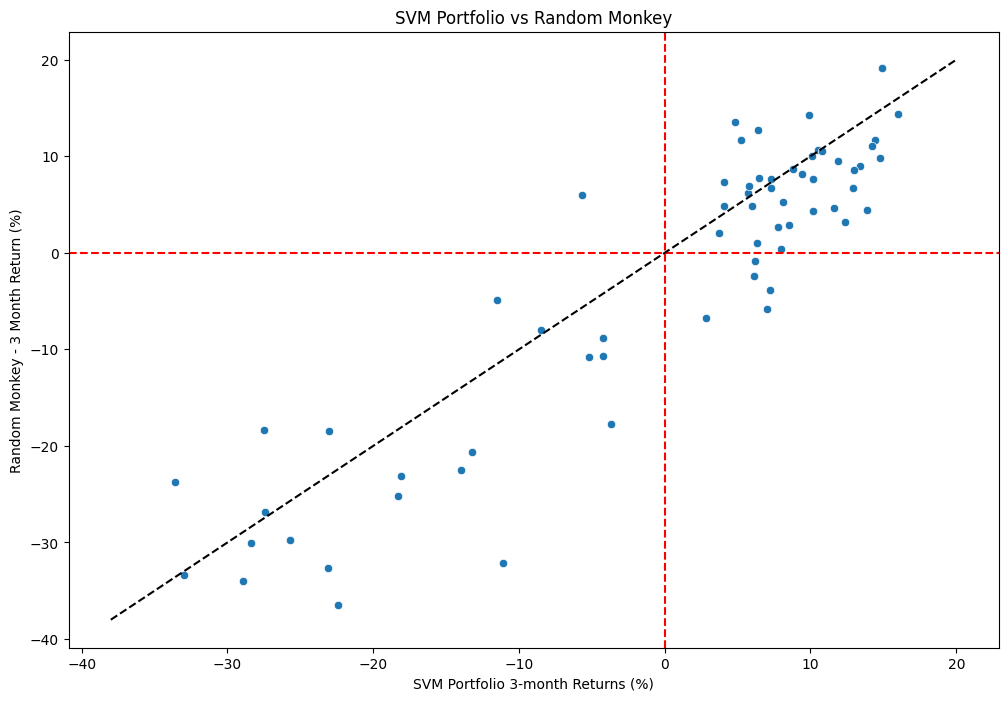

In [244]:
# make risk vs return plot
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.scatterplot(data=combined_returns, x='SVM Portfolio 3-month Returns (%)', y='Random Monkey 63-day Returns (%)')
# make 0 horizontal line
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
# Add diagonal line x=y
plt.plot([-38, 20], [-38, 20], color='black', linestyle='--')
plt.title('SVM Portfolio vs Random Monkey')
plt.ylabel('Random Monkey - 3 Month Return (%)')
plt.xlabel('SVM Portfolio 3-month Returns (%)')
plt.show()

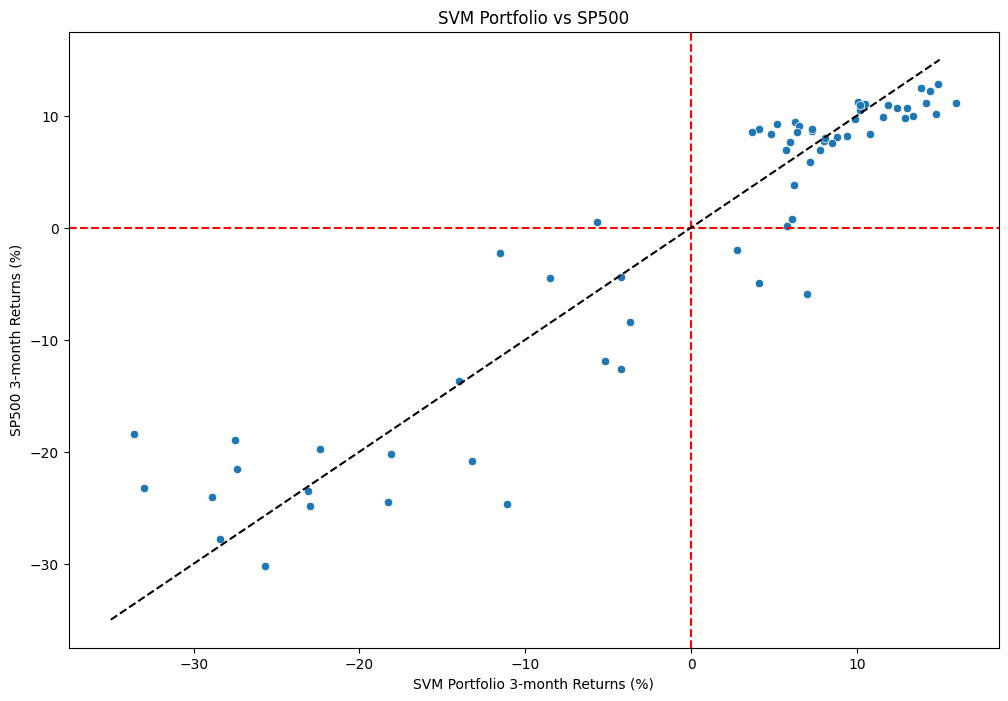

In [237]:
# make risk vs return plot
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.scatterplot(data=combined_returns, x='SVM Portfolio 3-month Returns (%)', y='S&P 500 - 3 Month Return (%)')
# make 0 horizontal line and vertical line
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
# Add diagonal line x=y
plt.plot([-35, 15], [-35, 15], color='black', linestyle='--')
plt.title('SVM Portfolio vs SP500')
plt.ylabel('SP500 3-month Returns (%)')
plt.xlabel('SVM Portfolio 3-month Returns (%)')
plt.show()